In [1]:
#Для выполнения задания использованы данные RLMS за 2008 г. (индивидуальная выборка) https://www.hse.ru/rlms/spss. 
#1. Описаны используемые данные. Дана краткая характеристика используемых переменных.
#2. Сформулирован исследовательский вопрос о зависимости уровня ЗП респондента от среднего уровня ЗП в регионе, образования и возраста (для модели 2), а также пола (для модели 1). Оценены соответствующие модели.
#3. Визуализированы используемые переменные.
#4. Оценены две регрессионные модели. С помощью теста сделан выбор между моделями. При проведении тестов и построении доверительных интервалов использованы робастные к гетероскедастичности методы. 
#5. Проведен тест Рамсея для отобранной модели. 
#6. Для отобранной модели проверено наличие мультикооллинеарности. 
#7. Выборка поделена на две части: обучающую и тестовую. На обучающей оценена простая модель, сложная модель и модель LASSO. Построены прогнозы на тестовую часть выборки. Выбрана наилучшая из моделей. 
#8. Для лучшей модели и выдуманного нового наблюдения построен новый прогноз и предиктивный интервал для прогноза. 
#9. Проверено наличие гетероскедастичности графически и с помощью формальных тестов.


In [2]:
import numpy as np # математические операции
import pandas as pd # операции с табличками
import statsmodels.formula.api as smf # модели 
from sklearn.linear_model import LinearRegression # линейная регрессия без статистики
import seaborn as sns # графики
import matplotlib.pyplot as plt # графики
from scipy import stats # про случайные величины
from pyreadstat import read_sav, set_value_labels
import matplotlib.ticker as tkr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white, het_goldfeldquandt
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.preprocessing import StandardScaler

In [3]:
import os
os.chdir('E:\Data\Study\Python\Dataset')

In [4]:
data1, meta = read_sav('r17i_os_42.sav', apply_value_formats = True)

In [5]:
#формирует вспомогательный массив для анализа
data_subset = data1[['mj13.2', 'popul', 'status', 'region', 'm_marst', 'm_educ', 'm_diplom', 'mh5', 'm_age', 'mj1', 'mj4.1', 'mj6.1a', 
                     'mj11.1', 'mj26']]

In [6]:
#переменная support - вспомогательный массив, содержащий среднюю ЗП в регионе по данным Росстат
support = pd.read_excel('support1.xlsx')

In [7]:
#добавляем среднюю заработную плату в регионе во вспомогательный массив
data_subset = pd.merge(data_subset, support, on='region', how='left')

In [8]:
#переименовываем названия столбцов
data_subset = data_subset.rename(columns={'mj13.2': 'salary', 'mj6.1a': 'working hours'})

In [9]:
#конвертируем количественные переменные
for col in ['salary', 'm_age', 'popul', 'working hours']:
  data_subset[col] = pd.to_numeric(data_subset[col], errors='coerce')

In [10]:
#отсеиваем респондентов, не указавших ЗП, а также респондентов моложе 18 лет (возраст дискретный) и добавляем значения в массив newdf, используемый для построения моделей
newdf = data_subset[(data_subset['salary'] > 0) & (data_subset['m_age'] > 17) & (data_subset['mj1'] == 'Вы сейчас работаете')]

In [11]:
#переименовываем названия столбцов
newdf = newdf.rename(columns={'m_marst': 'marriage', 'm_diplom': 'education', 'mh5': 'sex', 'm_age': 'age', 'mj1': 'is_working', 'mj4.1': 'industry', 'mj26': 'owner', 'mj11.1': 'work_legally', 'working hours': 'working_hours', 'AV payroll': 'Av_salary'})

In [12]:
#конвертируем качественные переменные
for col in ['region', 'marriage', 'education', 'sex', 'industry', 'is_working', 'industry', 'work_legally', 'owner']:
    newdf[col] = pd.Categorical(newdf[col])
newdf.dtypes

salary            float64
popul             float64
status           category
region           category
marriage         category
m_educ           category
education        category
sex              category
age               float64
is_working       category
industry         category
working_hours     float64
work_legally     category
owner            category
Av_salary         float64
dtype: object

In [13]:
#приводим все значения без ответа в единый формат
newdf = newdf.replace(['НЕТ ОТВЕТА', 'ЗАТРУДНЯЮСЬ ОТВЕТИТЬ', 'ОТКАЗ ОТ ОТВЕТА'], "нет ответа")
set(newdf['education'])

{'законченное высшее образование и выше',
 'законченное среднее образование',
 'законченное среднее специальное образование',
 'незаконченное среднее образование (7 - 8 кл)',
 'незаконченное среднее образование (7 - 8 кл) + что-то еще',
 'нет ответа',
 'окончил 0 - 6 классов'}

In [14]:
#уменьшаем на 1 количество качественных переменных (образование), т.к. значения похожи по смыслу
newdf = newdf.replace(['незаконченное среднее образование (7 - 8 кл) + что-то еще'], "незаконченное среднее образование (7 - 8 кл)")

In [15]:
#обрабатываем значения переменной industry для графиков 
set(newdf['industry'])
newdf = newdf.replace(['АРМИЯ, МВД, ОРГАНЫ БЕЗОПАСНОСТИ',
 'ВОЕННО-ПРОМЫШЛЕННЫЙ КОМПЛЕКС',
 'ГРАЖДАНСКОЕ МАШИНОСТРОЕНИЕ',
 'ДРУГАЯ ОТРАСЛЬ ТЯЖЕЛОЙ ПРОМЫШЛЕННОСТИ',
 'ДРУГОЕ',
 'ЖИЛИЩНО-КОММУНАЛЬНОЕ ХОЗЯЙСТВО',
 'ЗДРАВООХРАНЕНИЕ',
 'ЛЕГКАЯ, ПИЩЕВАЯ ПРОМЫШЛЕННОСТЬ',
 'НАУКА, КУЛЬТУРА',
 'НЕФТЕГАЗОВАЯ ПРОМЫШЛЕННОСТЬ',
 'ОБРАЗОВАНИЕ',
 'ОРГАНЫ УПРАВЛЕНИЯ',
 'СЕЛЬСКОЕ ХОЗЯЙСТВО',
 'СТРОИТЕЛЬСТВО',
 'ТОРГОВЛЯ, БЫТОВОЕ ОБСЛУЖИВАНИЕ',
 'ТРАНСПОРТ, СВЯЗЬ',
 'ФИНАНСЫ',
 'ЭНЕРГЕТИЧЕСКАЯ ПРОМЫШЛЕННОСТЬ'], 
                      ["Армия, МВД и т.д.", 
                       'ВПК', "Гражданское машиностроение", 
                       "Др. отрасль тяж. пром.", "Прочие отрасли",
                       "ЖКХ", "Здравоохранение", 
                       "Легкая и пищевая промышленность", 
                       "Наука, культура",
                       "Нефтегазовая промышленность", 
                       "Образование", "Органы управления", 
                       "Сельское хозяйство", "Строительство",
                       "Торговля, бытовое обслуживание", 
                       "Транспорт и связь", "Финансы", 
                       "Энергетическая промышленность"])


In [16]:
#описание данных (пункт 1)
newdf.describe()

,salary,popul,age,working_hours,Av_salary
count,3820.000000,3.820000e+03,3820.000000,3773.000000,3820.000000
mean,12545.726963,1.361966e+06,41.420157,9.415584,16528.710471
std,10524.878264,2.724313e+06,12.791627,4.015887,5885.462201
min,600.000000,3.000000e+01,18.000000,1.000000,9033.900000
25%,6000.000000,2.760000e+04,31.000000,8.000000,12153.800000
50%,10000.000000,2.000000e+05,42.000000,8.000000,14774.100000
75%,15000.000000,9.111000e+05,51.000000,10.000000,20826.900000
max,150000.000000,8.881200e+06,79.000000,24.000000,30552.100000


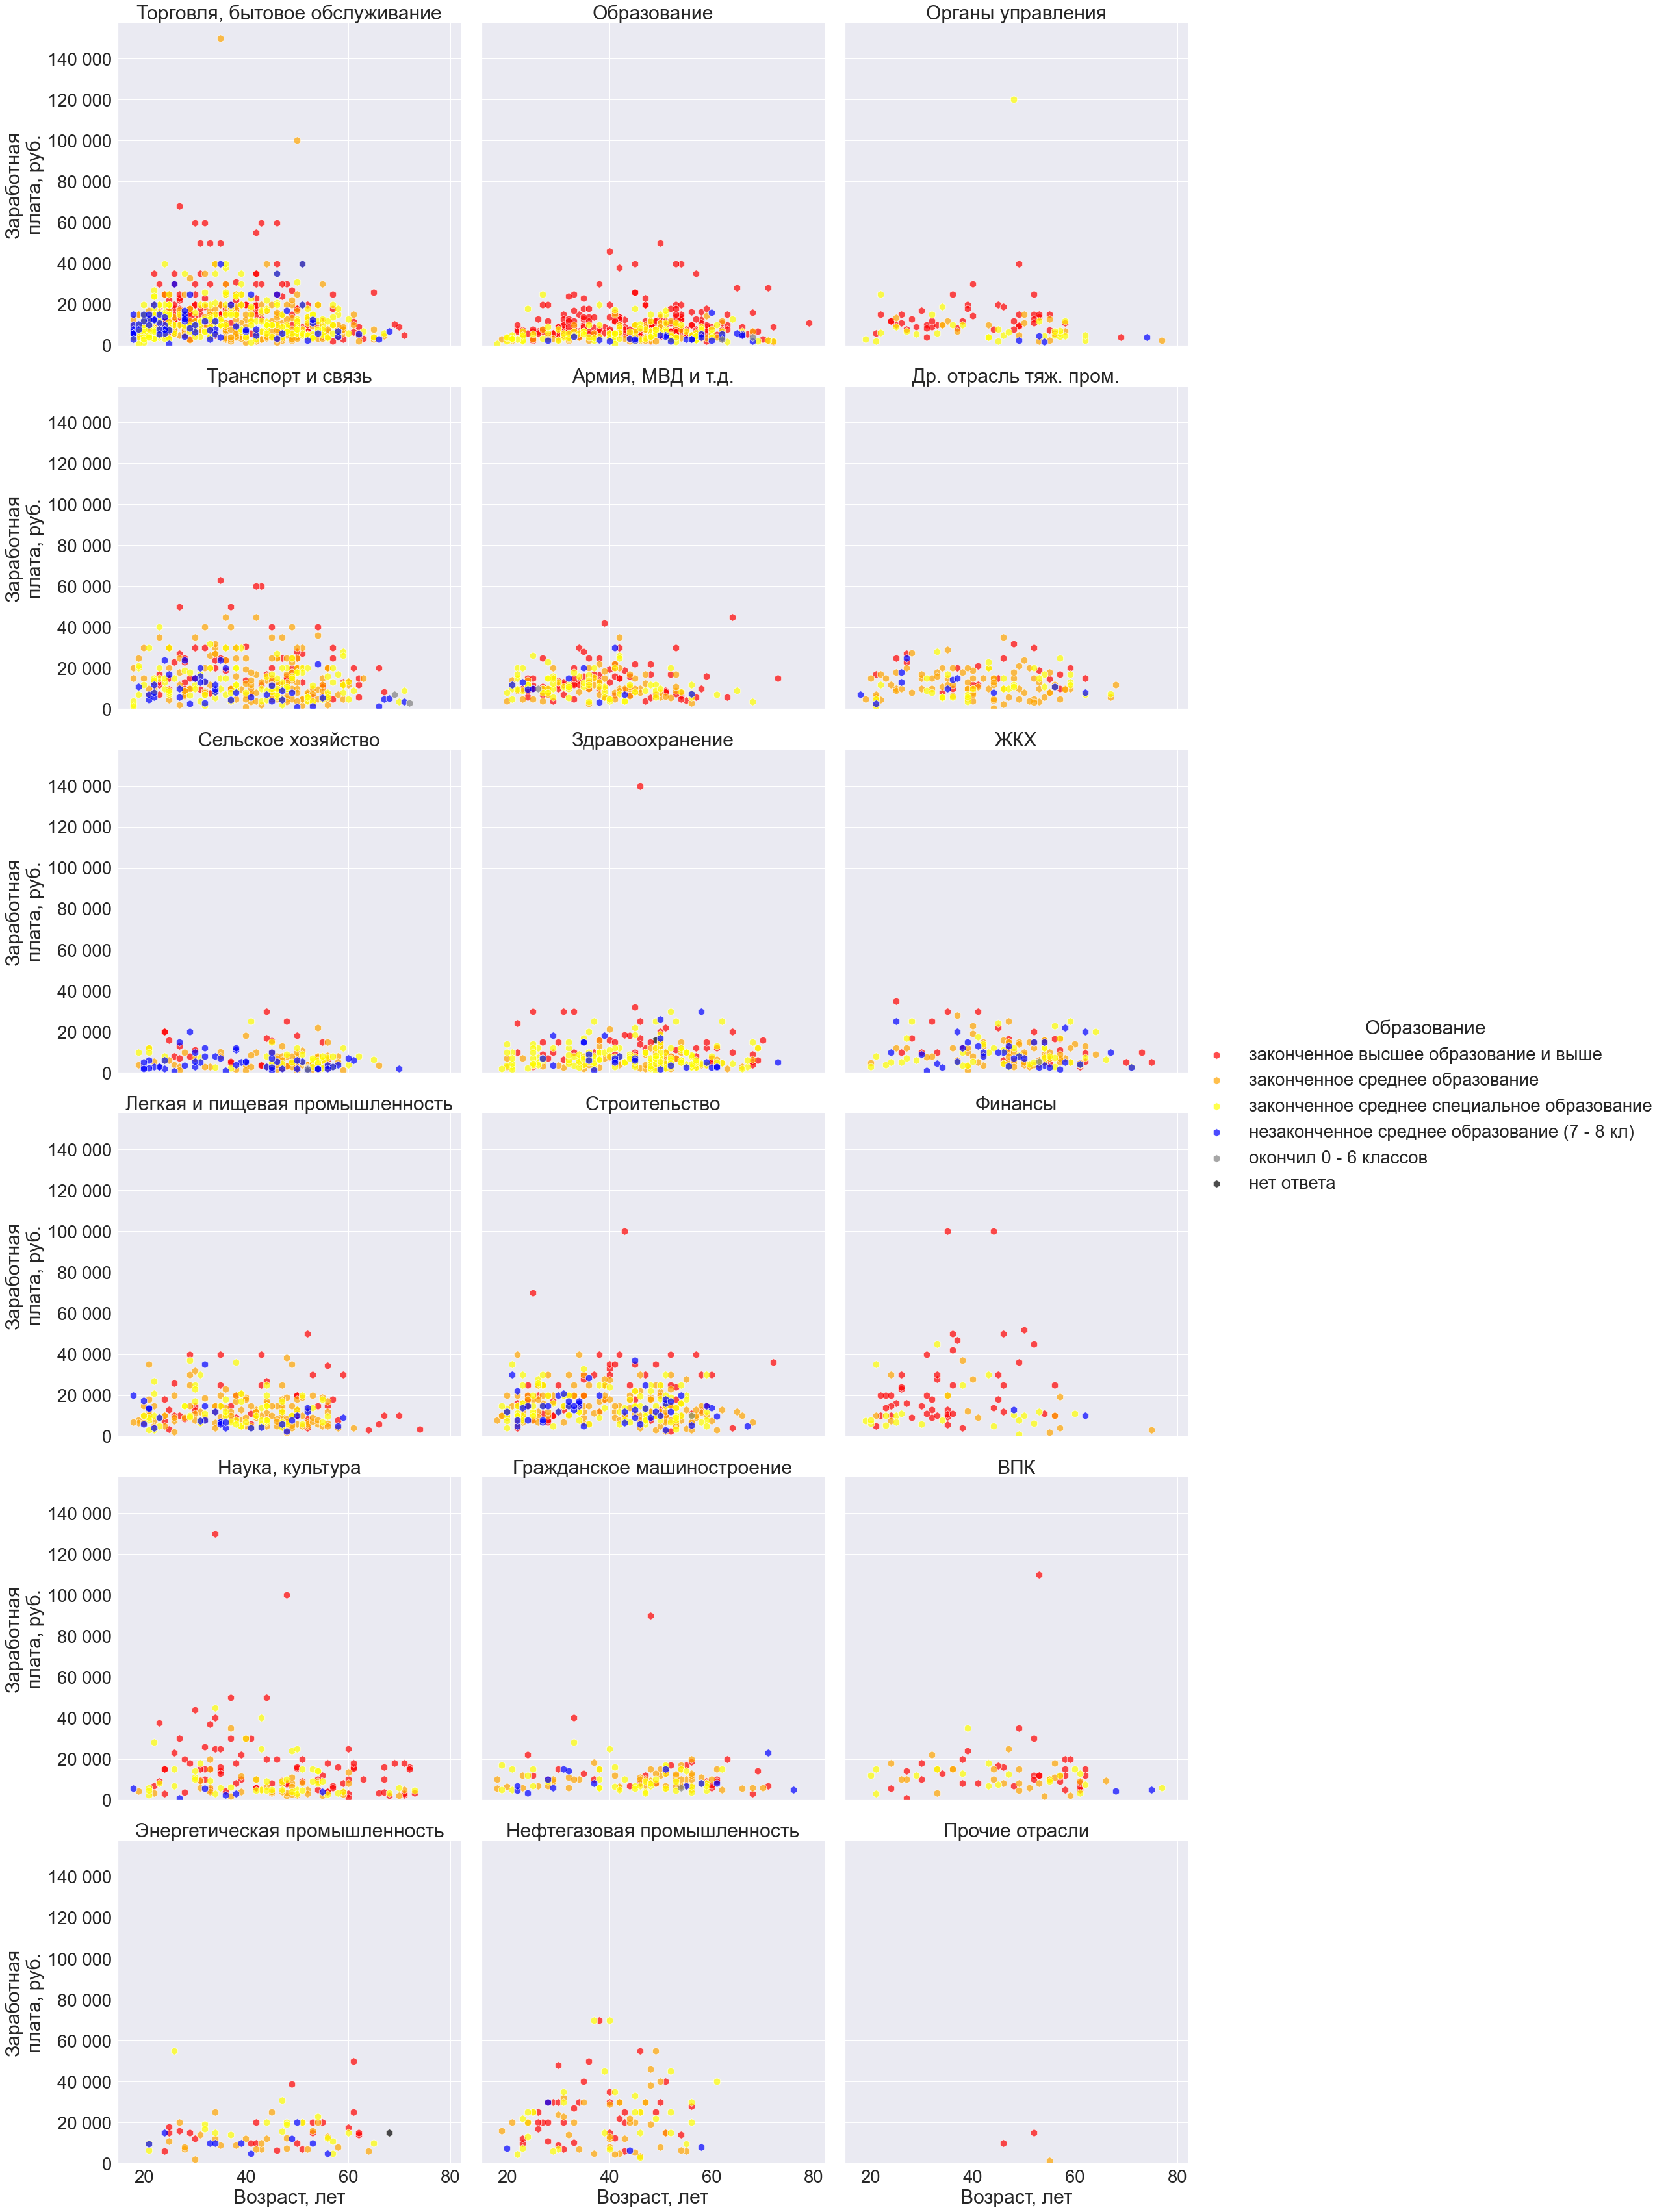

In [17]:
#формируем график (пункт 4)
sns.set(font_scale=2.5)
g = sns.FacetGrid(newdf, col="industry", hue="education", aspect=1.1, col_wrap=3, height=8,
                 palette ={"нет ответа": "black", "законченное высшее образование и выше": "red", "законченное среднее образование": "orange", 
                            "законченное среднее специальное образование": "yellow", "незаконченное среднее образование (7 - 8 кл)": "blue", "окончил 0 - 6 классов": "grey"})
g.map(sns.scatterplot, "age", "salary", alpha=.7, marker = 'h', s=140)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_ylabels('Заработная\nплата, руб.')
g.set_xlabels('Возраст, лет')
g.add_legend(title = 'Образование', label_order = ["законченное высшее образование и выше", "законченное среднее образование", "законченное среднее специальное образование",
                                                   "незаконченное среднее образование (7 - 8 кл)", "окончил 0 - 6 классов", "нет ответа",])
g.set(ylim=(0, None))
g.fig.subplots_adjust(hspace=0.127)

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y/1000:.0f}' + ' 000' if y != 0 else f'{y:.0f}'))


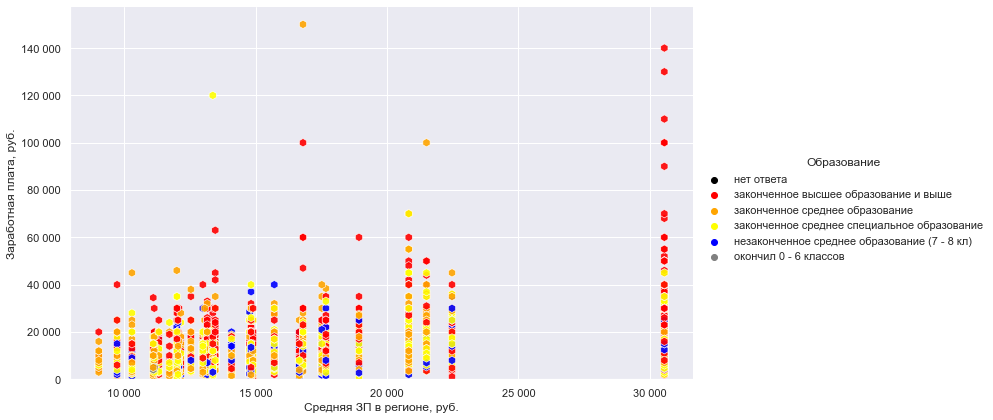

In [18]:
#формируем график (пункт 4)
sns.set_theme()

plot1 = sns.relplot(x="Av_salary", y="salary", hue="education",
            height=6, data=newdf,
           palette ={ "законченное высшее образование и выше": "red", "законченное среднее образование": "orange", "законченное среднее специальное образование": "yellow", "незаконченное среднее образование (7 - 8 кл)": "blue", "окончил 0 - 6 классов": "grey", "нет ответа": "black"},
           aspect = 1.7, legend = 'full', alpha = 0.9, s = 70, marker = 'h')
plot1.set_ylabels('Заработная плата, руб.')
plot1.set(ylim=(0, None))
plot1.set_xlabels('Средняя ЗП в регионе, руб.')
plot1._legend.set_title("Образование")
plot1._legend._legend_box.sep = 7
for ax in plot1.axes.flat:
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y/1000:.0f}' + ' 000' if y != 0 else f'{y:.0f}'))
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f'{x/1000:.0f}' + ' 000' if x != 0 else f'{x:.0f}'))

In [19]:
from numpy import log

In [20]:
#оцениваем модель 1 (пункт 2)
model4 = smf.ols(formula = 'salary ~ 1 + Av_salary + log(age) + education + industry + sex', data = newdf)

fit4 = model4.fit(cov_type = 'HC1')
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     56.56
Date:                Mon, 17 Jan 2022   Prob (F-statistic):          1.22e-238
Time:                        16:03:50   Log-Likelihood:                -39987.
No. Observations:                3820   AIC:                         8.003e+04
Df Residuals:                    3794   BIC:                         8.019e+04
Df Model:                          25                                         
Covariance Type:                  HC1                                         
=============================================================================================================================
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                  -731.6869   2571.122     -0.285      0.776   -5770.994    4307.620
education[T.законченное высшее образование и выше]         5304.8887   1964.924      2.700      0.007    1453.709    9156.068
education[T.законченное среднее образование]               -220.0782   1935.628     -0.114      0.909   -4013.840    3573.683
education[T.законченное среднее специальное образование]   1098.7745   1938.895      0.567      0.571   -2701.389    4898.938
education[T.незаконченное среднее образование (7 - 8 кл)] -1687.1631   1946.949     -0.867      0.386   -5503.113    2128.787
education[T.окончил 0 - 6 классов]                        -4991.9770   2476.464     -2.016      0.044   -9845.758    -138.196
industry[T.ВПК]                                            1612.8319   1379.508      1.169      0.242   -1090.955    4316.619
industry[T.Гражданское машиностроение]                      947.8974    774.012      1.225      0.221    -569.139    2464.934
industry[T.Др. отрасль тяж. пром.]                         2311.9152    638.699      3.620      0.000    1060.088    3563.743
industry[T.ЖКХ]                                            -959.4973    621.718     -1.543      0.123   -2178.043     259.048
industry[T.Здравоохранение]                                -365.8468    727.420     -0.503      0.615   -1791.564    1059.870
industry[T.Легкая и пищевая промышленность]                2147.4909    632.370      3.396      0.001     908.068    3386.913
industry[T.Наука, культура]                               -1202.6403   1078.712     -1.115      0.265   -3316.878     911.597
industry[T.Нефтегазовая промышленность]                    9731.7138   1311.618      7.420      0.000    7160.990    1.23e+04
industry[T.Образование]                                   -2554.6759    535.015     -4.775      0.000   -3603.287   -1506.065
industry[T.Органы управления]                               358.8727   1427.002      0.251      0.801   -2438.000    3155.745
industry[T.Прочие отрасли]                                -5784.3860   1061.332     -5.450      0.000   -7864.558   -3704.214
industry[T.Сельское хозяйство]                            -2689.1763    591.266     -4.548      0.000   -3848.036   -1530.317
industry[T.Строительство]                                  4168.5008    645.826      6.455      0.000    2902.705    5434.296
industry[T.Торговля, бытовое обслуживание]                 2035.3462    572.525      3.555      0.000     913.218    3157.474
industry[T.Транспорт и связь]                              2388.2626    628.183      3.802      0.000    1157.047    3619.478
industry[T.Финансы]                                        

In [21]:
#оцениваем модель 2 (пункт 2)
model5 = smf.ols(formula = 'salary ~ 1 + Av_salary + log(age) + education + industry', data = newdf)
fit5 = model5.fit(cov_type = 'HC1')
fit5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     54.27
Date:                Mon, 17 Jan 2022   Prob (F-statistic):          6.72e-222
Time:                        16:03:50   Log-Likelihood:                -40078.
No. Observations:                3820   AIC:                         8.021e+04
Df Residuals:                    3795   BIC:                         8.036e+04
Df Model:                          24                                         
Covariance Type:                  HC1                                         
=============================================================================================================================
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                  3210.1434   2344.237      1.369      0.171   -1384.478    7804.764
education[T.законченное высшее образование и выше]         5281.0057   1739.424      3.036      0.002    1871.797    8690.215
education[T.законченное среднее образование]                169.3082   1706.018      0.099      0.921   -3174.427    3513.043
education[T.законченное среднее специальное образование]    953.0849   1708.236      0.558      0.577   -2394.996    4301.166
education[T.незаконченное среднее образование (7 - 8 кл)]  -996.2055   1722.184     -0.578      0.563   -4371.625    2379.214
education[T.окончил 0 - 6 классов]                        -3680.1874   2305.931     -1.596      0.110   -8199.729     839.354
industry[T.ВПК]                                             873.9190   1420.776      0.615      0.538   -1910.750    3658.588
industry[T.Гражданское машиностроение]                      178.9163    792.785      0.226      0.821   -1374.914    1732.747
industry[T.Др. отрасль тяж. пром.]                         2230.0216    675.219      3.303      0.001     906.616    3553.427
industry[T.ЖКХ]                                           -1662.9035    643.872     -2.583      0.010   -2924.870    -400.937
industry[T.Здравоохранение]                               -2724.6205    678.703     -4.014      0.000   -4054.854   -1394.387
industry[T.Легкая и пищевая промышленность]                 877.7751    643.725      1.364      0.173    -383.903    2139.454
industry[T.Наука, культура]                               -2501.3459   1079.235     -2.318      0.020   -4616.607    -386.085
industry[T.Нефтегазовая промышленность]                    9422.3102   1333.831      7.064      0.000    6808.050     1.2e+04
industry[T.Образование]                                   -4725.6111    523.679     -9.024      0.000   -5752.002   -3699.220
industry[T.Органы управления]                             -1253.7911   1442.002     -0.869      0.385   -4080.063    1572.481
industry[T.Прочие отрасли]                                -5842.2141   2113.099     -2.765      0.006   -9983.812   -1700.616
industry[T.Сельское хозяйство]                            -3090.8594    601.872     -5.135      0.000   -4270.507   -1911.211
industry[T.Строительство]                                  4432.0096    661.841      6.696      0.000    3134.825    5729.194
industry[T.Торговля, бытовое обслуживание]                  420.2248    585.279      0.718      0.473    -726.901    1567.350
industry[T.Транспорт и связь]                              1966.7867    653.146      3.011      0.003     686.644    3246.929
industry[T.Финансы]                                        

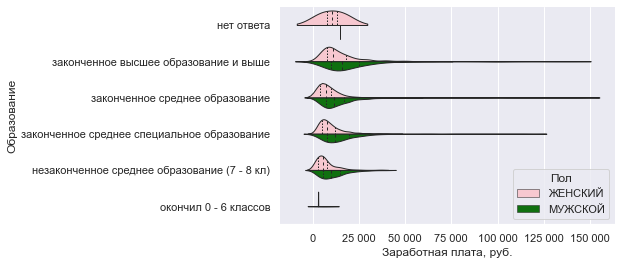

In [22]:
#формируем график распределения ЗП по полу и образованию (пункт 4)
sns.set_theme()


plot3 = sns.violinplot(data=newdf, x="salary", y="education", hue="sex",
               split=True, inner="quart", linewidth=1,
               palette={"МУЖСКОЙ": "GREEN", "ЖЕНСКИЙ": "PINK"}, legend = 'full')
sns.despine(left=True)
plot3.set(xlabel='Заработная плата, руб.',
           ylabel="Образование")
#plot3._legend.set_title("Пол")
plt.legend(loc='lower right', title = 'Пол')
plot3.xaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y/1000:.0f}' + ' 000' if y != 0 else f'{y:.0f}'))

[Text(0.5, 0, 'Возраст, лет.'), Text(0, 0.5, 'Число, чел.')]

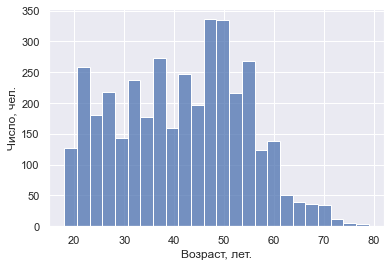

In [23]:
#формируем гистограмму распределения возрастов в выборке (пункт 4)
sns.set_theme()

plot4 = sns.histplot(newdf['age'])
plot4.set(xlabel='Возраст, лет.',
           ylabel="Число, чел.")

In [24]:
#формируем всомогательную корреляционную матрицу
corrmat = newdf.corr()

In [25]:
corrmat

,salary,popul,age,working_hours,Av_salary
salary,1.000000,0.369736,-0.090575,0.024762,0.437271
popul,0.369736,1.000000,-0.001262,-0.010791,0.839439
age,-0.090575,-0.001262,1.000000,0.013742,0.022218
working_hours,0.024762,-0.010791,0.013742,1.000000,0.012203
Av_salary,0.437271,0.839439,0.022218,0.012203,1.000000


In [26]:
#функция для сравнения двух фитов моделей при уровне уверенности lvl
def CompareXiTest(mfitR, mfitUR, lvl):
    """Получает CompareXiTest(fit() функции с ограничениями, fit() функции без ограничений, уровень уверенности)"""
    if int(mfitR.nobs) != int(mfitUR.nobs):
           return "Некорректно задана функция."
    restrictions = len(mfitUR.params)-len(mfitR.params)
    xi2obs = (mfitR.ssr - mfitUR.ssr)/((mfitUR.ssr)/(mfitUR.nobs-restrictions))
    xicr2 = stats.chi2(df=restrictions).ppf(lvl)
    return print("(Хи набл.: " + str(xi2obs) + ", Хи крит.: " + str(xicr2) + ", число ограничений: " + str(restrictions) + ")" + " => H0 отвергается" if xi2obs > xicr2 else "(Хи набл.: " + str(xi2obs) + ", Хи крит.: " + str(xicr2) + ", число ограничений: " + str(restrictions) + ")" + " => H0 не отвергается" )

In [27]:
#сравнение моделей (пункт 4)
CompareXiTest(fit5, fit4, 0.95)

(Хи набл.: 186.628290400005, Хи крит.: 3.841458820694124, число ограничений: 1) => H0 отвергается


In [28]:
# сравнение моделей F тестом (дополнительно) (пункт 4)
fit5.compare_f_test(fit4)

H:\ProgramFiles\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:2167: InvalidTestWarning: F test for comparison is likely invalid with robust covariance, proceeding anyway
  warnings.warn('F test for comparison is likely invalid with ' +


(176.81479925769452, nan, -1.0)

In [29]:
#сравнение моделей тестом Вальда (пункт 4)
fit4.wald_test("Av_salary=0, log(age) = 0, sex[T.МУЖСКОЙ] = 0")

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[505.17790704]], p-value=3.601891951019497e-109, df_denom=3>

In [30]:
#нахождение Хи кв. крит (пункт 4)
stats.chi2(df=1).ppf(0.975)

5.023886187314888

In [31]:
#функция теста Рамсея (пункт 5)
def RamseyTest(dataframe, fit, formula):
    """
    Получает RamseyTest(Датафрейм с данными, фит модели, формула модели)
    """
    RTdata = dataframe.copy()
    RTdata['yhat'] = fit.fittedvalues
    formulaRT = formula + " + I(yhat ** 2) + I(yhat ** 3)"
    ramsey = smf.ols(formulaRT, data=RTdata).fit()
    return ramsey.f_test('I(yhat ** 2) = 0,  I(yhat ** 3) = 0')

    

In [32]:
#вспомогательная формула для теста Рамсея (пункт 5)
formula1 = 'salary ~ 1 + Av_salary + log(age) + education + industry + sex'

In [33]:
RamseyTest(newdf, fit4, formula1) 

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[31.83083172]]), p=1.9530538430156175e-14, df_denom=3.8e+03, df_num=2>

In [34]:
#расчет VIF (пункт 6)
def VIFfast(dataframe, yname:str):
    X = dataframe.drop(columns=yname)
    X['ones']=1
    return [variance_inflation_factor(X.values, i) for i in range(0, len(X.columns)-1)]

In [35]:
#исключение факторных переменных для расчета (пункт 6)
X = newdf.drop(columns='salary')
X = X.select_dtypes(exclude=['object'])
X = X.select_dtypes(exclude=['category'])
X['ones']=1
X = X.drop(columns='popul')
X = X.drop(columns = 'working_hours')
X
[variance_inflation_factor(X.values, i) for i in [0, 1, 2]]

[1.000493886237429, 1.0004938862374293, 18.981662657905858]

In [36]:
X

,age,Av_salary,ones
0,24.0,17519.0,1
2,62.0,17519.0,1
3,54.0,17519.0,1
4,51.0,17519.0,1
5,32.0,17519.0,1
...,...,...,...
9867,26.0,22473.4,1
9869,21.0,22473.4,1
9870,41.0,22473.4,1
9872,24.0,22473.4,1


In [37]:
#проводим тест Вайта (пункт 9)
het_white(model4.fit().resid, model4.fit().model.exog)

(254.4349277411109,
 9.30382389451074e-08,
 1.7825170807934605,
 4.168288744463768e-08)

In [38]:
print(model4.fit().model.exog[0])

[1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.75190000e+04 3.17805383e+00]


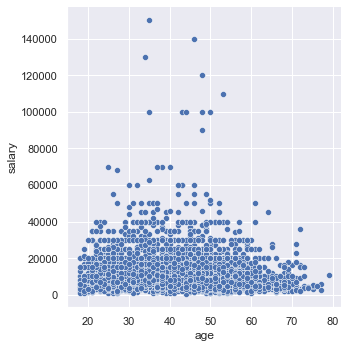

In [39]:
#визуальная проверка распределения ЗП по возрасту респондентов для проверки гетероскедастичности (пункт 9)
sns.set_theme()
sns.relplot(data = newdf, x = 'age', y = 'salary')

In [40]:
#проводим тест Голдфелда-Квандта (пункт 9)
het_goldfeldquandt(y=model4.fit().model.endog,
                   x=model4.fit().model.exog,
                   idx=24,
                   drop=0.2,
                   alternative='increasing')

(4.045323330862362, 2.037781134807966e-127, 'increasing')

In [41]:
#расчет y оцененного
newdf['yhat'] = fit4.predict(newdf)

In [42]:
#расчет остатков в модели
newdf['Res'] = newdf['salary']-newdf['yhat']

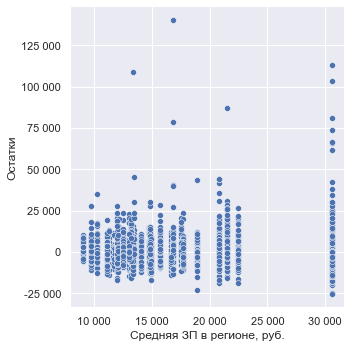

In [43]:
#визуальный тест гетераскедастичности по остаткам (пункт 9)
sns.set_theme()

plot5 = sns.relplot(data = newdf, x = 'Av_salary', y = 'Res')
for ax in plot5.axes.flat:
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y/1000:.0f}' + ' 000' if y != 0 else f'{y:.0f}'))
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f'{x/1000:.0f}' + ' 000' if x != 0 else f'{x:.0f}'))
plot5.set(xlabel='Средняя ЗП в регионе, руб.', ylabel="Остатки")

In [44]:
#разбиваем массив на обучающую и тестовую выборки, df1 - обучающая, df2 - тестовая (пункт 7)
df1 = newdf.iloc[:3800, :]
df2 = newdf.iloc[3800:, :]

In [45]:
#оцениваем вспомогательную модель 1 по обучающей выборке (пункт 7)
model4new = smf.ols(formula = 'salary ~ 1 + Av_salary + log(age) + education + industry + sex', data = df1)

fit4new = model4new.fit(cov_type = 'HC1')
fit4new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     56.09
Date:                Mon, 17 Jan 2022   Prob (F-statistic):          1.28e-236
Time:                        16:03:51   Log-Likelihood:                -39779.
No. Observations:                3800   AIC:                         7.961e+04
Df Residuals:                    3774   BIC:                         7.977e+04
Df Model:                          25                                         
Covariance Type:                  HC1                                         
=============================================================================================================================
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                  -806.7192   2571.337     -0.314      0.754   -5846.448    4233.009
education[T.законченное высшее образование и выше]         5322.4621   1964.005      2.710      0.007    1473.082    9171.842
education[T.законченное среднее образование]               -191.1906   1934.590     -0.099      0.921   -3982.917    3600.536
education[T.законченное среднее специальное образование]   1130.4815   1937.923      0.583      0.560   -2667.777    4928.740
education[T.незаконченное среднее образование (7 - 8 кл)] -1710.8998   1945.819     -0.879      0.379   -5524.635    2102.835
education[T.окончил 0 - 6 классов]                        -4955.2510   2473.769     -2.003      0.045   -9803.748    -106.754
industry[T.ВПК]                                            1603.2699   1379.721      1.162      0.245   -1100.934    4307.474
industry[T.Гражданское машиностроение]                      779.1389    766.745      1.016      0.310    -723.653    2281.931
industry[T.Др. отрасль тяж. пром.]                         2238.0633    637.111      3.513      0.000     989.349    3486.778
industry[T.ЖКХ]                                           -1031.2150    622.053     -1.658      0.097   -2250.417     187.987
industry[T.Здравоохранение]                                -359.4174    728.732     -0.493      0.622   -1787.706    1068.871
industry[T.Легкая и пищевая промышленность]                2171.5568    634.573      3.422      0.001     927.817    3415.297
industry[T.Наука, культура]                               -1206.3476   1078.803     -1.118      0.263   -3320.762     908.067
industry[T.Нефтегазовая промышленность]                    9731.8807   1311.626      7.420      0.000    7161.142    1.23e+04
industry[T.Образование]                                   -2541.2058    535.181     -4.748      0.000   -3590.141   -1492.270
industry[T.Органы управления]                               348.4637   1427.125      0.244      0.807   -2448.650    3145.577
industry[T.Прочие отрасли]                                -5788.6816   1058.834     -5.467      0.000   -7863.957   -3713.406
industry[T.Сельское хозяйство]                            -2685.7711    591.257     -4.542      0.000   -3844.614   -1526.929
industry[T.Строительство]                                  4173.1385    645.827      6.462      0.000    2907.342    5438.935
industry[T.Торговля, бытовое обслуживание]                 2022.6336    574.019      3.524      0.000     897.576    3147.691
industry[T.Транспорт и связь]                              2392.4218    629.101      3.803      0.000    1159.407    3625.437
industry[T.Финансы]                                        

In [46]:
#оцениваем вспомогательную модель 2 по обучающей выборке (пункт 7)
model5new = smf.ols(formula = 'salary ~ 1 + Av_salary + log(age) + education + industry', data = df1)
fit5new = model5.fit(cov_type = 'HC1')
fit5new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     54.27
Date:                Mon, 17 Jan 2022   Prob (F-statistic):          6.72e-222
Time:                        16:03:51   Log-Likelihood:                -40078.
No. Observations:                3820   AIC:                         8.021e+04
Df Residuals:                    3795   BIC:                         8.036e+04
Df Model:                          24                                         
Covariance Type:                  HC1                                         
=============================================================================================================================
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                  3210.1434   2344.237      1.369      0.171   -1384.478    7804.764
education[T.законченное высшее образование и выше]         5281.0057   1739.424      3.036      0.002    1871.797    8690.215
education[T.законченное среднее образование]                169.3082   1706.018      0.099      0.921   -3174.427    3513.043
education[T.законченное среднее специальное образование]    953.0849   1708.236      0.558      0.577   -2394.996    4301.166
education[T.незаконченное среднее образование (7 - 8 кл)]  -996.2055   1722.184     -0.578      0.563   -4371.625    2379.214
education[T.окончил 0 - 6 классов]                        -3680.1874   2305.931     -1.596      0.110   -8199.729     839.354
industry[T.ВПК]                                             873.9190   1420.776      0.615      0.538   -1910.750    3658.588
industry[T.Гражданское машиностроение]                      178.9163    792.785      0.226      0.821   -1374.914    1732.747
industry[T.Др. отрасль тяж. пром.]                         2230.0216    675.219      3.303      0.001     906.616    3553.427
industry[T.ЖКХ]                                           -1662.9035    643.872     -2.583      0.010   -2924.870    -400.937
industry[T.Здравоохранение]                               -2724.6205    678.703     -4.014      0.000   -4054.854   -1394.387
industry[T.Легкая и пищевая промышленность]                 877.7751    643.725      1.364      0.173    -383.903    2139.454
industry[T.Наука, культура]                               -2501.3459   1079.235     -2.318      0.020   -4616.607    -386.085
industry[T.Нефтегазовая промышленность]                    9422.3102   1333.831      7.064      0.000    6808.050     1.2e+04
industry[T.Образование]                                   -4725.6111    523.679     -9.024      0.000   -5752.002   -3699.220
industry[T.Органы управления]                             -1253.7911   1442.002     -0.869      0.385   -4080.063    1572.481
industry[T.Прочие отрасли]                                -5842.2141   2113.099     -2.765      0.006   -9983.812   -1700.616
industry[T.Сельское хозяйство]                            -3090.8594    601.872     -5.135      0.000   -4270.507   -1911.211
industry[T.Строительство]                                  4432.0096    661.841      6.696      0.000    3134.825    5729.194
industry[T.Торговля, бытовое обслуживание]                  420.2248    585.279      0.718      0.473    -726.901    1567.350
industry[T.Транспорт и связь]                              1966.7867    653.146      3.011      0.003     686.644    3246.929
industry[T.Финансы]                                        

In [47]:
#получаем экзогенные переменные из вспомогательной модели 1 (пункт 7)
exog = pd.DataFrame(model4new.fit().model.exog)

In [48]:
exog

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,17519.0,3.178054
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17519.0,4.127134
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17519.0,3.988984
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,17519.0,3.931826
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,17519.0,3.465736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22473.4,3.713572
3796,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22473.4,3.951244
3797,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,22473.4,3.178054
3798,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,22473.4,3.583519


In [49]:
y = df1['salary']

In [50]:
X = df1[['Av_salary', 'sex', 'age', 'education', 'industry']]

In [51]:
X['log(age)'] = np.log(X['age'])

C:\Users\COMPUT~1\AppData\Local\Temp/ipykernel_9528/3589389032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['log(age)'] = np.log(X['age'])


In [52]:
X = X.drop(columns = 'age')

In [53]:
tempdf = pd.DataFrame(fit4new.summary().tables[1].data)

In [54]:
print(*tempdf[0], sep = "\", \"")

", "Intercept", "education[T.законченное высшее образование и выше]", "education[T.законченное среднее образование]", "education[T.законченное среднее специальное образование]", "education[T.незаконченное среднее образование (7 - 8 кл)]", "education[T.окончил 0 - 6 классов]", "industry[T.ВПК]", "industry[T.Гражданское машиностроение]", "industry[T.Др. отрасль тяж. пром.]", "industry[T.ЖКХ]", "industry[T.Здравоохранение]", "industry[T.Легкая и пищевая промышленность]", "industry[T.Наука, культура]", "industry[T.Нефтегазовая промышленность]", "industry[T.Образование]", "industry[T.Органы управления]", "industry[T.Прочие отрасли]", "industry[T.Сельское хозяйство]", "industry[T.Строительство]", "industry[T.Торговля, бытовое обслуживание]", "industry[T.Транспорт и связь]", "industry[T.Финансы]", "industry[T.Энергетическая промышленность]", "sex[T.МУЖСКОЙ]", "Av_salary", "log(age)


In [55]:
#переименование колонок в exog для лучшего понимания качественных переменных
exog.columns = ["Intercept", "education[T.законченное высшее образование и выше]", "education[T.законченное среднее образование]", "education[T.законченное среднее специальное образование]", "education[T.незаконченное среднее образование (7 - 8 кл)]", "education[T.окончил 0 - 6 классов]", "industry[T.ВПК]", "industry[T.Гражданское машиностроение]", "industry[T.Др. отрасль тяж. пром.]", "industry[T.ЖКХ]", "industry[T.Здравоохранение]", "industry[T.Легкая и пищевая промышленность]", "industry[T.Наука, культура]", "industry[T.Нефтегазовая промышленность]", "industry[T.Образование]", "industry[T.Органы управления]", "industry[T.Прочие отрасли]", "industry[T.Сельское хозяйство]", "industry[T.Строительство]", "industry[T.Торговля, бытовое обслуживание]", "industry[T.Транспорт и связь]", "industry[T.Финансы]", "industry[T.Энергетическая промышленность]", "sex[T.МУЖСКОЙ]", "Av_salary", "log(age)"]

In [56]:
exog

,Intercept,education[T.законченное высшее образование и выше],education[T.законченное среднее образование],education[T.законченное среднее специальное образование],education[T.незаконченное среднее образование (7 - 8 кл)],education[T.окончил 0 - 6 классов],industry[T.ВПК],industry[T.Гражданское машиностроение],industry[T.Др. отрасль тяж. пром.],industry[T.ЖКХ],...,industry[T.Прочие отрасли],industry[T.Сельское хозяйство],industry[T.Строительство],"industry[T.Торговля, бытовое обслуживание]",industry[T.Транспорт и связь],industry[T.Финансы],industry[T.Энергетическая промышленность],sex[T.МУЖСКОЙ],Av_salary,log(age)
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,17519.0,3.178054
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17519.0,4.127134
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17519.0,3.988984
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,17519.0,3.931826
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,17519.0,3.465736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22473.4,3.713572
3796,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22473.4,3.951244
3797,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,22473.4,3.178054
3798,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,22473.4,3.583519


In [57]:
#оцениваем модель ЛАССО с лямбда = 1 (пункт 7)
modelLASSO = ElasticNet(alpha=1, l1_ratio=1, normalize=True, fit_intercept = False).fit(exog, y)

H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137655368567.5957, tolerance: 101720253.4772
  model = cd_fast.enet_coordinate_descent(


In [58]:
for i in range(len(modelLASSO.coef_)):
    print(int(modelLASSO.coef_[i]))

-397
5170
-326
979
-1842
-4671
1449
639
2100
-1118
-458
2039
-1289
9586
-2643
198
-4618
-2779
4050
1898
2269
6319
2352
4187
0
-894


In [59]:
modelLASSO.score(exog, y)

0.34596067941418573

In [60]:
#ищем наилучшее лямбда в модели ЛАССО для увеличения R^2 (пункт 7)
more_alphas = np.arange(0.000001, 1, 0.01)
fit = ElasticNetCV(l1_ratio=1, alphas=more_alphas, normalize=True, cv=10, random_state=555, fit_intercept = False).fit(exog, y)

H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131673474437.25694, tolerance: 97247700.7732
  model = cd_fast.enet_coordinate_descent_gram(
H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263067064.01815796, tolerance: 97247700.7732
  model = cd_fast.enet_coordinate_descent_gram(
H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1384666478.232727, tolerance: 97247700.7732
  model = cd_fast.enet_coordinate_descent_gram(
H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceW

H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2413160847.515747, tolerance: 95897205.58430001
  model = cd_fast.enet_coordinate_descent_gram(
H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4904521431.844574, tolerance: 95897205.58430001
  model = cd_fast.enet_coordinate_descent_gram(
H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8099985528.218384, tolerance: 95897205.58430001
  model = cd_fast.enet_coordinate_descent_gram(
H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: Co

H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 666232013.112915, tolerance: 90571217.0654
  model = cd_fast.enet_coordinate_descent_gram(
H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2169877469.688904, tolerance: 90571217.0654
  model = cd_fast.enet_coordinate_descent_gram(
H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4501791743.684418, tolerance: 90571217.0654
  model = cd_fast.enet_coordinate_descent_gram(
H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarn

H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 398563433.50335693, tolerance: 89201026.94960001
  model = cd_fast.enet_coordinate_descent_gram(
H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1705997200.1785278, tolerance: 89201026.94960001
  model = cd_fast.enet_coordinate_descent_gram(
H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3926105964.5811768, tolerance: 89201026.94960001
  model = cd_fast.enet_coordinate_descent_gram(
H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526:

H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121236789087.05453, tolerance: 90777720.78760001
  model = cd_fast.enet_coordinate_descent_gram(
H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116394008094.29103, tolerance: 86642676.54720001
  model = cd_fast.enet_coordinate_descent_gram(
H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114608475803.52673, tolerance: 86642676.54720001
  model = cd_fast.enet_coordinate_descent_gram(
H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526:

H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137657852134.35492, tolerance: 101720253.4772
  model = cd_fast.enet_coordinate_descent(


In [61]:
#наилучшее лямбда - 0.990001 (пункт 7)
fit.alpha_

0.990001

In [62]:
#оцениваем модель лассо с наилучшим лямбда (пункт 7)
lasso_best = ElasticNet(alpha=1, l1_ratio=1, normalize=True, fit_intercept = False).fit(exog, y)

H:\ProgramFiles\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137655368567.5957, tolerance: 101720253.4772
  model = cd_fast.enet_coordinate_descent(


In [63]:
lasso_best.coef_

array([-3.97566814e+02,  5.17059478e+03, -3.26491850e+02,  9.79832027e+02,
       -1.84296356e+03, -4.67184169e+03,  1.44999061e+03,  6.39322256e+02,
        2.10095102e+03, -1.11883067e+03, -4.58889208e+02,  2.03932832e+03,
       -1.28993054e+03,  9.58683116e+03, -2.64357575e+03,  1.98002078e+02,
       -4.61812067e+03, -2.77919929e+03,  4.05013515e+03,  1.89872819e+03,
        2.26921593e+03,  6.31920751e+03,  2.35204725e+03,  4.18715539e+03,
        7.15068882e-01, -8.94028714e+02])

In [64]:
#R^2 модели ЛАССО (пункт 7)
lasso_best.score(exog, y)

0.34596067941418573

In [65]:
#формируем таблицы для отчета (пункт 7)
LASSO_COEF = pd.DataFrame(lasso_best.coef_)
LASSO_COEF = LASSO_COEF.T
LASSO_COEF.columns = ["Intercept", "education[T.законченное высшее образование и выше]", "education[T.законченное среднее образование]", "education[T.законченное среднее специальное образование]", "education[T.незаконченное среднее образование (7 - 8 кл)]", "education[T.окончил 0 - 6 классов]", "industry[T.ВПК]", "industry[T.Гражданское машиностроение]", "industry[T.Др. отрасль тяж. пром.]", "industry[T.ЖКХ]", "industry[T.Здравоохранение]", "industry[T.Легкая и пищевая промышленность]", "industry[T.Наука, культура]", "industry[T.Нефтегазовая промышленность]", "industry[T.Образование]", "industry[T.Органы управления]", "industry[T.Прочие отрасли]", "industry[T.Сельское хозяйство]", "industry[T.Строительство]", "industry[T.Торговля, бытовое обслуживание]", "industry[T.Транспорт и связь]", "industry[T.Финансы]", "industry[T.Энергетическая промышленность]", "sex[T.МУЖСКОЙ]", "Av_salary", "log(age)"]

In [66]:
LASSO_COEF = LASSO_COEF.T 

In [67]:
data5 = pd.DataFrame(fit5new.summary().tables[1].data)
data5
new_header5 = data5.iloc[0]
data5 = data5[1:]
data5.columns = new_header5
data5.columns = ['coef', "Model5", "Ошибка", "Z", "P", "Нижняя граница", "Верхняя граница"]

In [68]:
data4 = pd.DataFrame(fit4new.summary().tables[1].data)
data4
new_header4 = data4.iloc[0]
data4 = data4[1:]
data4.columns = new_header4
data4.columns = ['coef', "Model4", "Ошибка", "Z", "P", "Нижняя граница", "Верхняя граница"]

In [69]:
LASSO_COEF.reset_index(level=0, inplace=True)

In [70]:
LASSO_COEF.columns = ['coef', "LASSO"]

In [71]:
LASSO_COEF

,coef,LASSO
0,Intercept,-397.566814
1,education[T.законченное высшее образование и в...,5170.594778
2,education[T.законченное среднее образование],-326.491850
3,education[T.законченное среднее специальное об...,979.832027
4,education[T.незаконченное среднее образование ...,-1842.963562
5,education[T.окончил 0 - 6 классов],-4671.841686
6,industry[T.ВПК],1449.990614
7,industry[T.Гражданское машиностроение],639.322256
8,industry[T.Др. отрасль тяж. пром.],2100.951022
9,industry[T.ЖКХ],-1118.830668


In [72]:
#формируем таблицы модели лассо, модели 1 и 2, оцененные по обучающей выборке (пункт 7)
LASSO_COEF = pd.merge(LASSO_COEF, data4, on='coef', how='left')

In [73]:
LASSO_COEF = pd.merge(LASSO_COEF, data5, on='coef', how='left')

In [74]:
#формируем таблицы модели лассо, модели 1 и 2, оцененные по обучающей выборке (пункт 7)
LASSO_COEF.to_excel("lasso coef.xlsx")

In [75]:
#делаем предсказания в модели 1 по тестовой выборке (пункт 7)
prediction4_1 = fit4new.get_prediction(df2).summary_frame(alpha=0.99)

In [76]:
#делаем предсказания в модели 2 по тестовой выборке (пункт 7)
prediction5_1 = fit5new.get_prediction(df2).summary_frame(alpha=0.99)

In [77]:
prediction4_1

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,13976.375236,586.177701,13969.028396,13983.722077,13869.059425,14083.691048
1,18215.237367,567.359302,18208.126387,18222.348348,18107.937445,18322.537290
2,10747.148109,378.185522,10742.408133,10751.888086,10639.979202,10854.317016
3,15927.472003,549.393411,15920.586197,15934.357808,15820.186768,16034.757238
4,13221.298724,577.183335,13214.064614,13228.532833,13113.990571,13328.606876
5,18477.514980,549.699035,18470.625344,18484.404617,18370.229500,18584.800461
6,18380.164341,805.356180,18370.070434,18390.258248,18272.625537,18487.703144
7,18226.028268,768.449888,18216.396925,18235.659611,18118.531896,18333.524640
8,14059.669041,533.482002,14052.982661,14066.355421,13952.396421,14166.941661
9,14775.683321,422.263487,14770.390894,14780.975748,14668.488559,14882.878083


In [78]:
#оцениваем вспомогательную модель для получения матрицы регрессоров с качественными переменными (df2exog) для последующего предсказания в модели Лассо (пункт 7)
testmodel = smf.ols(formula = 'salary ~ 1 + Av_salary + log(age) + education + industry + sex', data = df2)

testfit = testmodel.fit(cov_type = 'HC1')
testfit.summary()

H:\ProgramFiles\Anaconda\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 10
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     6.452
Date:                Mon, 17 Jan 2022   Prob (F-statistic):             0.0166
Time:                        16:03:53   Log-Likelihood:                -198.01
No. Observations:                  20   AIC:                             424.0
Df Residuals:                       6   BIC:                             438.0
Df Model:                          13                                         
Covariance Type:                  HC1                                         
=============================================================================================================================
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                  7.847e+04   8.68e+04      0.903      0.366   -9.18e+04    2.49e+05
education[T.законченное высшее образование и выше]         2.396e+04   2.29e+04      1.046      0.295   -2.09e+04    6.88e+04
education[T.законченное среднее образование]               2.654e+04   3.17e+04      0.838      0.402   -3.55e+04    8.86e+04
education[T.законченное среднее специальное образование]     1.6e+04   1.94e+04      0.824      0.410   -2.21e+04    5.41e+04
education[T.незаконченное среднее образование (7 - 8 кл)]  1.196e+04   1.49e+04      0.803      0.422   -1.72e+04    4.11e+04
education[T.окончил 0 - 6 классов]                         5.593e-11   6.38e-11      0.876      0.381   -6.92e-11    1.81e-10
industry[T.Др. отрасль тяж. пром.]                        -1.511e+04   2.16e+04     -0.700      0.484   -5.75e+04    2.72e+04
industry[T.ЖКХ]                                           -1.254e+04   1.05e+04     -1.199      0.231    -3.3e+04    7958.672
industry[T.Здравоохранение]                               -1.812e+04   1.34e+04     -1.351      0.177   -4.44e+04    8161.799
industry[T.Легкая и пищевая промышленность]               -2.066e+04   1.68e+04     -1.227      0.220   -5.37e+04    1.23e+04
industry[T.Образование]                                   -1.051e+04   1.06e+04     -0.989      0.323   -3.13e+04    1.03e+04
industry[T.Торговля, бытовое обслуживание]                 -1.28e+04   1.51e+04     -0.846      0.398   -4.25e+04    1.69e+04
industry[T.Транспорт и связь]                             -1.288e+04    1.6e+04     -0.806      0.420   -4.42e+04    1.85e+04
sex[T.МУЖСКОЙ]                                             1.517e+04   8231.352      1.843      0.065    -961.046    3.13e+04
Av_salary                                                     0.5928      0.794      0.747      0.455      -0.963       2.149
log(age)                                                  -2.514e+04   2.74e+04     -0.919      0.358   -7.88e+04    2.85e+04
==============================================================================
Omnibus:                        1.817   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.403   Jarque-Bera (JB):                0.657
Skew:                           0.403   Prob(JB):                        0.720
Kurtosis:                       3.371   Cond. No.                     3.64e+20
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The smallest eigenvalue is 7.37e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
""

In [79]:
testpd = pd.DataFrame(testfit.summary().tables[1].data)
print(*testpd[0], sep = '\", \"')

", "Intercept", "education[T.законченное высшее образование и выше]", "education[T.законченное среднее образование]", "education[T.законченное среднее специальное образование]", "education[T.незаконченное среднее образование (7 - 8 кл)]", "education[T.окончил 0 - 6 классов]", "industry[T.Др. отрасль тяж. пром.]", "industry[T.ЖКХ]", "industry[T.Здравоохранение]", "industry[T.Легкая и пищевая промышленность]", "industry[T.Образование]", "industry[T.Торговля, бытовое обслуживание]", "industry[T.Транспорт и связь]", "sex[T.МУЖСКОЙ]", "Av_salary", "log(age)


In [80]:
df2exog = pd.DataFrame(testfit.model.exog)
df2exog.columns = ["Intercept", "education[T.законченное высшее образование и выше]", "education[T.законченное среднее образование]", "education[T.законченное среднее специальное образование]", "education[T.незаконченное среднее образование (7 - 8 кл)]", "education[T.окончил 0 - 6 классов]", "industry[T.Др. отрасль тяж. пром.]", "industry[T.ЖКХ]", "industry[T.Здравоохранение]", "industry[T.Легкая и пищевая промышленность]", "industry[T.Образование]", "industry[T.Торговля, бытовое обслуживание]", "industry[T.Транспорт и связь]", "sex[T.МУЖСКОЙ]", "Av_salary", "log(age)"]

In [81]:
df2exog

,Intercept,education[T.законченное высшее образование и выше],education[T.законченное среднее образование],education[T.законченное среднее специальное образование],education[T.незаконченное среднее образование (7 - 8 кл)],education[T.окончил 0 - 6 классов],industry[T.Др. отрасль тяж. пром.],industry[T.ЖКХ],industry[T.Здравоохранение],industry[T.Легкая и пищевая промышленность],industry[T.Образование],"industry[T.Торговля, бытовое обслуживание]",industry[T.Транспорт и связь],sex[T.МУЖСКОЙ],Av_salary,log(age)
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,22473.4,3.218876
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,22473.4,3.784190
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,22473.4,3.637586
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,22473.4,3.091042
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,22473.4,3.295837
5,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22473.4,3.555348
6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22473.4,3.496508
7,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22473.4,3.688879
8,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,22473.4,3.555348
9,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,22473.4,3.828641


In [82]:
#с учетом того, что в тестовой выборке были не все качественные переменные, матрица df2exog уже необходимой (16 против 26) (пункт 7)
exog.to_excel("exog.xlsx")

In [83]:
df2exog.to_excel("df2exog.xlsx")

In [84]:
#результаты обработки были загружены на гитхаб (пункт 7)
df2lasso = pd.read_excel('df2LASSO.xlsx')

In [85]:
df2lasso = df2lasso.drop(columns = 'Unnamed: 0')

In [86]:
df2lasso

,Intercept,education[T.законченное высшее образование и выше],education[T.законченное среднее образование],education[T.законченное среднее специальное образование],education[T.незаконченное среднее образование (7 - 8 кл)],education[T.окончил 0 - 6 классов],industry[T.ВПК],industry[T.Гражданское машиностроение],industry[T.Др. отрасль тяж. пром.],industry[T.ЖКХ],...,industry[T.Прочие отрасли],industry[T.Сельское хозяйство],industry[T.Строительство],"industry[T.Торговля, бытовое обслуживание]",industry[T.Транспорт и связь],industry[T.Финансы],industry[T.Энергетическая промышленность],sex[T.МУЖСКОЙ],Av_salary,log(age)
0,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,22473.4,3.218876
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,22473.4,3.784190
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,22473.4,3.637586
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,22473.4,3.091042
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,22473.4,3.295837
5,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,22473.4,3.555348
6,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,22473.4,3.496508
7,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,22473.4,3.688879
8,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,22473.4,3.555348
9,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,22473.4,3.828641


In [87]:
#формируем таблицу предсказаний по модели ЛАССО (пункт 7)
lassopred = pd.DataFrame(lasso_best.predict(df2lasso))
lassopred

,0
0,14020.055952
1,18189.279876
2,10756.612001
3,15928.141842
4,13246.832227
5,18455.493513
6,17717.078821
7,17541.485469
8,14066.115289
9,14776.565884


In [88]:
#соединяем таблицы
pred5 = pd.concat([lassopred, prediction4_1['mean']], axis = 1)

In [89]:
pred5 = pd.concat([pred5, prediction5_1['mean']], axis = 1)

In [90]:
df2y = df2['salary']

In [91]:
df2y = df2y.reset_index(drop=True)

In [92]:
pred5 = pd.concat([pred5, df2y], axis = 1)

In [93]:
#находим RSS по каждому из предсказаний в тестовой выборке, чтобы определить отклонения (пункт 7)
pred5["LASSO Residiuals"] = (pred5['LASSO'] - pred5['Y'])**2
pred5["Модель1 Residiuals"] = (pred5['Модель 1'] - pred5['Y'])**2
pred5["Модель2 Residiuals"] = (pred5['Модель 2'] - pred5['Y'])**2

KeyError: 'LASSO'

In [ ]:
pred5['LASSO Residiuals'].sum()

In [ ]:
pred5["Модель1 Residiuals"].sum()

In [ ]:
pred5["Модель2 Residiuals"].sum()

In [ ]:
#минимальный РСС в модели 1 (пункт 7)
min(pred5['LASSO Residiuals'].sum(), pred5["Модель1 Residiuals"].sum(), pred5["Модель2 Residiuals"].sum())

In [ ]:
#формируем предсказания по выбранной ранее модели 1 (пункт 8)
prediction2 = pd.DataFrame({'Av_salary': [21000, 22000, 29000], "sex": ["ЖЕНСКИЙ", "ЖЕНСКИЙ", "МУЖСКОЙ"], "age": [25, 31, 42], 'industry': ['ВПК', "Наука, культура", "Здравоохранение"], 'education': ['законченное среднее образование', "законченное высшее образование и выше", 'законченное высшее образование и выше']})

prediction2

In [ ]:
predictionNEW = fit4.get_prediction(prediction2).summary_frame(alpha=0.99)
predictionNEW

In [ ]:
#средний возраст респондента в выборке (пункт 1)
newdf['age'].mean()

In [ ]:
#медианный возраст респондента в выборке (пункт 1)
newdf['age'].median()

In [ ]:
#подсчет долей в выборке (пункт 1)
newdf['sex'][newdf['sex']=='ЖЕНСКИЙ'].count

In [ ]:
#доля женщин в выборке (пункт 1)
2083/len(newdf)

In [ ]:
#средняя и медианная ЗП (пункт 1)
print(str(newdf['salary'].mean()) + " " + str(newdf['salary'].median()))

In [ ]:
#формируем таблицы для отчета
fit4table = pd.DataFrame(fit4.summary().tables[1].data)
fit4table
fit4table.to_excel('fit4table.xlsx')

In [ ]:
fit5table = pd.DataFrame(fit5.summary().tables[1].data)
fit5table
fit5table.to_excel('fit5table.xlsx')

In [ ]:
fit4new.summary().tables[1].to_excel('fit4new.xlsx')
fit5new.summary().tables[1].to_excel('fit5new.xlsx')


In [ ]:
exog.corr().to_excel("corr.xlsx")

In [ ]:
prediction2.to_excel('pred2.xlsx')

In [ ]:
predictionNEW.to_excel('prednew.xlsx')

In [ ]:
pred5.to_excel('pred5 new.xlsx')